Import Libraries

In [135]:
import os
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from random import sample
import random

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### KNN function

In [137]:
def knn(reducedTrainD, reducedTestD, labelsTrain, labelsTest, k ):
  c=KNeighborsClassifier(n_neighbors = k)
  c.fit(reducedTrainD,labelsTrain)
  labelsPred=c.predict(reducedTestD)
  accuracy = metrics.accuracy_score(labelsTest, labelsPred)
  return accuracy

## Part 2 : Generate the Data Matrix and the Label vector

In [138]:
# D = [] # Data matrix
# y = [] # Labels
# for i in range(1,41): # 40 people
#   for j in range(1,11): # 10 images per person
#     img_name = "faces/s"+str(i)+"/"+str(j)+".pgm" # Image name
#     img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE) # Read image
#     img = img.flatten() # Flatten image
#     D.append(img) # Add image to data matrix
#     y.append(i) # Add label to labels
# D = np.array(D) # Convert to numpy array
# y = np.array(y) # Convert to numpy array

D = []
y = []
for i in range(1,41):
  for j in range(1,11):
    img_name = "/content/drive/MyDrive/faces/s"+str(i)+"/"+str(j)+".pgm"
    img = cv2.imread(img_name,cv2.IMREAD_GRAYSCALE)
    img = img.flatten()
    D.append(img)
    y.append(i)
D = np.array(D)
y = np.array(y)
D.shape   

(400, 10304)

## Part 3 : Split the Dataset into Training and Test sets

In [65]:
# testData = np.array([D[i] for i in range(0,400,3)]) # Test data
# trainData = np.array([D[i] for i in range(0,400,7)]) # Train data

# testLabel = np.array([y[i] for i in range(0,120,1)]) # Test labels
# trainLabel = np.array([y[i] for i in range(120,400,1)]) # Train labels

In [143]:
trainData ,testData=[] , []
trainLabel, testLabel= [], []
s=0
for i in range(0,400,1):
  if s < 7:
    trainData.append(D[i])
    trainLabel.append(y[i])
    
  else:
    testData.append(D[i])
    testLabel.append(y[i])
    #print(i, end=",")
  s=s+1

  if s==10:
    s=0
trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

In [108]:
print(trainData.shape)
print(testData.shape)
print(testLabel.shape)
print(trainLabel.shape)

(280, 10304)
(120, 10304)
(120,)
(280,)


## Part4 : Classification using PCA

Compute Mean

In [109]:
trainMean = np.mean(trainData, axis=0) # Compute Train mean
testMean= np.mean(testData, axis=0) # Compute Test mean
print(trainMean)
print(testMean)
trainMean.shape

[82.91785714 85.29642857 85.69642857 ... 74.73571429 74.15
 73.25357143]
[82.46666667 86.15833333 86.6        ... 81.85833333 79.76666667
 79.64166667]


(10304,)

Center the Data

In [110]:
trainCenter= trainData - trainMean # Center train data
testCenter= testData- testMean # Center test data

Compute Covariance Matrix

In [111]:
cova=np.cov(trainCenter, rowvar=False, bias=True) # Compute covariance matrix

Get Eigen vectors and Eigen Values of covariance matrix

In [112]:
eigenVal, eigenVec = np.linalg.eigh(cova) # Compute eigenvalues and eigenvectors
indices = eigenVal.argsort()[::-1] # Get the indices that would sort an array in descending order
eigenVal=eigenVal[indices] # get eigenvalues in descending order
eigenVec=eigenVec[:,indices] # get eigenvectors in descending order
print(eigenVal)
print("\n")
print(eigenVec)
eigenVec.shape

[ 2.92681447e+06  2.03802513e+06  1.13108628e+06 ... -1.12928409e-09
 -1.46578372e-09 -1.69284156e-09]


[[ 3.86094331e-03 -1.02518580e-02 -2.01187863e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.09428928e-03 -1.41596018e-02 -2.11482640e-02 ...  6.91358989e-02
   3.53543206e-01 -5.24030553e-01]
 [ 4.06944935e-03 -1.42393556e-02 -2.09417575e-02 ... -1.53977278e-01
  -4.29025095e-01 -2.92980510e-01]
 ...
 [ 5.57568801e-03  1.20965478e-02 -1.11565965e-02 ... -8.38389834e-03
  -2.17353191e-02  2.42392954e-03]
 [ 5.40038317e-03  1.14172238e-02 -1.16745287e-02 ... -8.25252255e-03
  -1.66443159e-04 -3.62503857e-03]
 [ 6.41043790e-03  1.02504422e-02 -1.24709074e-02 ...  1.25915020e-02
   5.76704673e-03 -1.65282543e-02]]


(10304, 10304)

Project the training set, and test sets separately for differenet alpha

In [161]:
alpha=np.array([0.8,0.85,0.9,0.95])
accuracies=np.array([])
totval= np.sum(eigenVal)
explained=0
for a in alpha:
  r=0
  sum=0
  while explained <= a:
    sum = sum+eigenVal[r]
    explained=sum/totval
    r=r+1
  
  if a==0.8:
    p1=eigenVec[:,:r]
    reducedTrain1=np.dot(trainCenter, p1)
    reducedTest1=np.dot(testCenter, p1)
    a1=knn(reducedTrain1,reducedTest1,trainLabel, testLabel,1)
    r1=r
  elif a==0.85:
    p2=eigenVec[:,:r]
    reducedTrain2=np.dot(trainCenter, p2)
    reducedTest2=np.dot(testCenter, p2)
    r2=r
  elif a==0.9:
    p3=eigenVec[:,:r]
    reducedTrain3=np.dot(trainCenter, p3)
    reducedTest3=np.dot(testCenter, p3)
    r3=r
  else:
    p4=eigenVec[:,:r]
    reducedTrain4=np.dot(trainCenter, p4)
    reducedTest4=np.dot(testCenter, p4)
    r4=r

In [162]:

for a in alpha:
  print("\n")
  print("alpha =", a)
  print("n-neighbors=", 1)
  if a==0.8:
    a1=knn(reducedTrain1,reducedTest1,trainLabel, testLabel,1)
    accuracies=np.append(accuracies,a1)
    print("dimensions=", r1)
    print("accuracy:", a1)
  elif a==0.85:
    a2=knn(reducedTrain2,reducedTest2,trainLabel, testLabel,1)
    accuracies=np.append(accuracies,a2)
    print("dimensions=", r2)
    print("accuracy:", a2)
  elif a==0.9:
    a3=knn(reducedTrain3,reducedTest3,trainLabel, testLabel,1)
    accuracies=np.append(accuracies,a3)
    print("dimensions=", r3)
    print("accuracy:", a3)
  else:
      a4=knn(reducedTrain4,reducedTest4,trainLabel, testLabel,1)
      accuracies=np.append(accuracies,a4)
      print("dimensions=", r4)
      print("accuracy:", a4)



alpha = 0.8
n-neighbors= 1
dimensions= 39
accuracy: 0.9583333333333334


alpha = 0.85
n-neighbors= 1
dimensions= 58
accuracy: 0.9583333333333334


alpha = 0.9
n-neighbors= 1
dimensions= 89
accuracy: 0.95


alpha = 0.95
n-neighbors= 1
dimensions= 145
accuracy: 0.9416666666666667


Relation between alpha and classification accuracy

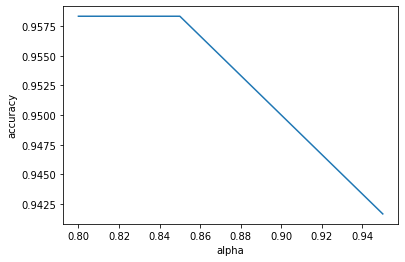

In [115]:
plt.plot(alpha, accuracies)
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.show()

## Classification Using LDA

Calculate the mean vector for every class Mu1, Mu2, ..., Mu40


In [116]:
Mu = np.zeros((40,10304)) # 40 means, each of size 10304
for i in range(40): # For each person
  Mu[i] = np.mean(trainData[i*5:i*5+5], axis=0) # Compute mean of 5 images

In [117]:
Mu

array([[54.8, 56.4, 55. , ..., 36.8, 30.6, 34.4],
       [24.4, 38.4, 40.8, ..., 78.2, 78.4, 79.6],
       [48.8, 48.6, 49.2, ..., 54. , 51.4, 52.4],
       ...,
       [57.4, 59.8, 57.2, ..., 34. , 32.6, 34.4],
       [79.4, 78.8, 79.6, ..., 80.4, 80. , 74.8],
       [94.2, 92.2, 90.6, ..., 69.8, 70.4, 73.8]])

Generate class specific subsets


In [118]:
D = np.zeros((40,5,10304)) # 40 people, 5 images per person, each image of size 10304
for i in range(40):
  D[i] = trainData[i*5:i*5+5]
  

In [119]:
D

array([[[ 48.,  49.,  45., ...,  47.,  46.,  46.],
        [ 60.,  60.,  62., ...,  32.,  34.,  34.],
        [ 39.,  44.,  53., ...,  29.,  26.,  29.],
        [ 63.,  53.,  35., ...,  41.,  10.,  24.],
        [ 64.,  76.,  80., ...,  35.,  37.,  39.]],

       [[ 10.,  43.,  50., ..., 156., 155., 158.],
        [ 10.,  41.,  47., ...,  39.,  35.,  37.],
        [ 35.,  36.,  37., ..., 144., 147., 143.],
        [ 37.,  35.,  35., ...,  26.,  28.,  28.],
        [ 30.,  37.,  35., ...,  26.,  27.,  32.]],

       [[ 34.,  36.,  35., ...,  32.,  25.,  25.],
        [ 35.,  32.,  36., ...,  25.,  28.,  29.],
        [ 34.,  35.,  35., ...,  31.,  24.,  24.],
        [ 38.,  35.,  36., ..., 138., 142., 141.],
        [103., 105., 104., ...,  44.,  38.,  43.]],

       ...,

       [[ 39.,  46.,  42., ...,  19.,  19.,  25.],
        [ 46.,  45.,  42., ...,  24.,  21.,  24.],
        [ 38.,  46.,  38., ...,  27.,  23.,  26.],
        [ 42.,  40.,  43., ...,  23.,  23.,  18.],
        [122

Mean Vector for every class

In [120]:
μ = np.mean(D, axis=1)

In [121]:
μ

array([[54.8, 56.4, 55. , ..., 36.8, 30.6, 34.4],
       [24.4, 38.4, 40.8, ..., 78.2, 78.4, 79.6],
       [48.8, 48.6, 49.2, ..., 54. , 51.4, 52.4],
       ...,
       [57.4, 59.8, 57.2, ..., 34. , 32.6, 34.4],
       [79.4, 78.8, 79.6, ..., 80.4, 80. , 74.8],
       [94.2, 92.2, 90.6, ..., 69.8, 70.4, 73.8]])

Calculate the between class metrices

In [122]:
Sb = np.zeros((10304,10304)) # Between class scatter matrix
for i in range(40):
  Sb[i] = 5*np.matmul((μ[i] - trainMean).T, (μ[i] - trainMean))

In [123]:
Sb

array([[67939669.75529335, 67939669.75529335, 67939669.75529335, ...,
        67939669.75529335, 67939669.75529335, 67939669.75529335],
       [36884160.66243622, 36884160.66243622, 36884160.66243622, ...,
        36884160.66243622, 36884160.66243622, 36884160.66243622],
       [21974254.07672194, 21974254.07672194, 21974254.07672194, ...,
        21974254.07672194, 21974254.07672194, 21974254.07672194],
       ...,
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [       0.        ,        0.        ,        0.        , ...,
               0.        ,        0.        ,        0.        ]])

Compute cener class matrices

In [124]:
# Compute Z
Z = np.zeros((40,5,10304)) # 40 people, 5 images per person, each image of size 10304
for i in range(40):
    Z[i] = D[i] - μ[i].T 

In [125]:
Z

array([[[ -6.8,  -7.4, -10. , ...,  10.2,  15.4,  11.6],
        [  5.2,   3.6,   7. , ...,  -4.8,   3.4,  -0.4],
        [-15.8, -12.4,  -2. , ...,  -7.8,  -4.6,  -5.4],
        [  8.2,  -3.4, -20. , ...,   4.2, -20.6, -10.4],
        [  9.2,  19.6,  25. , ...,  -1.8,   6.4,   4.6]],

       [[-14.4,   4.6,   9.2, ...,  77.8,  76.6,  78.4],
        [-14.4,   2.6,   6.2, ..., -39.2, -43.4, -42.6],
        [ 10.6,  -2.4,  -3.8, ...,  65.8,  68.6,  63.4],
        [ 12.6,  -3.4,  -5.8, ..., -52.2, -50.4, -51.6],
        [  5.6,  -1.4,  -5.8, ..., -52.2, -51.4, -47.6]],

       [[-14.8, -12.6, -14.2, ..., -22. , -26.4, -27.4],
        [-13.8, -16.6, -13.2, ..., -29. , -23.4, -23.4],
        [-14.8, -13.6, -14.2, ..., -23. , -27.4, -28.4],
        [-10.8, -13.6, -13.2, ...,  84. ,  90.6,  88.6],
        [ 54.2,  56.4,  54.8, ..., -10. , -13.4,  -9.4]],

       ...,

       [[-18.4, -13.8, -15.2, ..., -15. , -13.6,  -9.4],
        [-11.4, -14.8, -15.2, ..., -10. , -11.6, -10.4],
        [-19

Compute class scatter matrices

In [126]:
S = np.zeros((10304,10304))  # Within class scatter matrix
for i in range(40):
  S += np.matmul(Z[i].T, Z[i])
  

In [127]:
S

array([[106217.6,  74927.4,  74527.4, ...,  -9157. ,  -2394.4,   3197.6],
       [ 74927.4,  96832.8,  95210.2, ...,   6521.8,  14179.8,  18224.8],
       [ 74527.4,  95210.2,  95982.8, ...,   7027.8,  15111.6,  18770.8],
       ...,
       [ -9157. ,   6521.8,   7027.8, ..., 132488.8,  92535.4,  74645. ],
       [ -2394.4,  14179.8,  15111.6, ...,  92535.4, 103158.4,  85904.6],
       [  3197.6,  18224.8,  18770.8, ...,  74645. ,  85904.6, 104954. ]])

compute S inverse

In [128]:
S_inverse = np.linalg.inv(S)

In [129]:
S_inverse

array([[ 5.19237102e+09,  5.39689034e+08,  1.58008607e+09, ...,
         3.57070869e+09,  1.48499414e+09,  2.25463619e+09],
       [-1.27811072e+10, -2.60845292e+09,  1.44891790e+08, ...,
         3.77194052e+08, -1.07565107e+08, -7.08860662e+08],
       [ 4.71473202e+07, -1.29163373e+10, -1.46920503e+08, ...,
         2.09372766e+09, -1.36474970e+09, -4.05449563e+09],
       ...,
       [-6.50879543e+08, -6.99396616e+08, -2.57122325e+08, ...,
        -7.39508584e+08,  1.74908413e+08, -9.14989028e+08],
       [-3.83409904e+09, -7.97516401e+08, -1.65093909e+08, ...,
        -2.34698354e+08,  3.24485266e+08, -1.17526057e+09],
       [-2.70893060e+09,  6.32671777e+08,  1.42128812e+08, ...,
         9.36274577e+06, -2.21236757e+08, -4.52761859e+07]])

Compute eigenvalues and eigenvectors

In [130]:
eigVal, eigVec = np.linalg.eigh((S_inverse @ Sb))

In [145]:
eigVal

array([-1.17896976e+21, -3.88266495e+20, -2.33506745e+20, ...,
        2.35806809e+20,  3.83956485e+20,  1.19359286e+21])

In [146]:
eigVec

array([[ 0.00974609, -0.00984949,  0.00946993, ..., -0.00913698,
         0.00973171,  0.00965848],
       [ 0.00976635, -0.00991165,  0.00956931, ..., -0.00904203,
         0.0096696 ,  0.00963865],
       [ 0.00975372, -0.00987281,  0.00950708, ..., -0.00910087,
         0.00970817,  0.00965099],
       ...,
       [ 0.00464252,  0.00454243,  0.0045438 , ...,  0.00473598,
         0.00460621, -0.00461278],
       [ 0.0166671 ,  0.01628044,  0.01625839, ...,  0.01708715,
         0.01659243, -0.01658753],
       [ 0.00808721,  0.00790063,  0.00789095, ...,  0.00828783,
         0.00804887, -0.00804757]])

Use 39 dominant eigenvectors instead of just one

In [147]:
weights = eigVec[:,-39:]
weights

array([[-0.01152749,  0.00570585,  0.06014435, ..., -0.00913698,
         0.00973171,  0.00965848],
       [-0.00968684,  0.00481998,  0.05101178, ..., -0.00904203,
         0.0096696 ,  0.00963865],
       [-0.01074183,  0.00532894,  0.05626848, ..., -0.00910087,
         0.00970817,  0.00965099],
       ...,
       [ 0.0031519 ,  0.00733425, -0.00076369, ...,  0.00473598,
         0.00460621, -0.00461278],
       [ 0.01209072,  0.02808181, -0.00291985, ...,  0.01708715,
         0.01659243, -0.01658753],
       [ 0.00583743,  0.01355981, -0.00141005, ...,  0.00828783,
         0.00804887, -0.00804757]])

Project the training set, and test sets separately using the same projection matrix U

In [148]:
projectedTrain = weights.T @ trainData.T
projectedTest = weights.T @ testData.T


In [149]:
projectedTest.shape

(39, 120)

Apply KNN

In [150]:
result = knn(projectedTrain.T, projectedTest.T, trainLabel, testLabel,1 )

Accuracy for the multi class LDA

In [151]:
print("Accuracy:", result)

Accuracy: 0.925


Compare the results to PCA results.

In [163]:
# Compare PCA vs LDA results
print("PCA Accuracy:", a3)
print("LDA Accuracy:", result)

PCA Accuracy: 0.95
LDA Accuracy: 0.925


## Part 6 Classifier Tuning

Compare PCA result with different K and alpha

In [153]:
for k in range(1, 8, 2):
    for a in alpha:
        # print("\n")
        # print("alpha =", a , "dimensions=", r)
        # print("n-neighbors=", 1)
        if a==0.8:
            a1=knn(reducedTrain1,reducedTest1,trainLabel, testLabel,k)
            accuracies=np.append(accuracies,a1)
            # print("accuracy:", a1)
        elif a==0.85:
            a2=knn(reducedTrain2,reducedTest2,trainLabel, testLabel,k)
            accuracies=np.append(accuracies,a2)
            # print("accuracy:", a2)
        elif a==0.9:
            a3=knn(reducedTrain3,reducedTest3,trainLabel, testLabel,k)
            accuracies=np.append(accuracies,a3)
            # print("accuracy:", a3)
        else:
            a4=knn(reducedTrain4,reducedTest4,trainLabel, testLabel,k)
            accuracies=np.append(accuracies,a4)
            # print("accuracy:", a4)

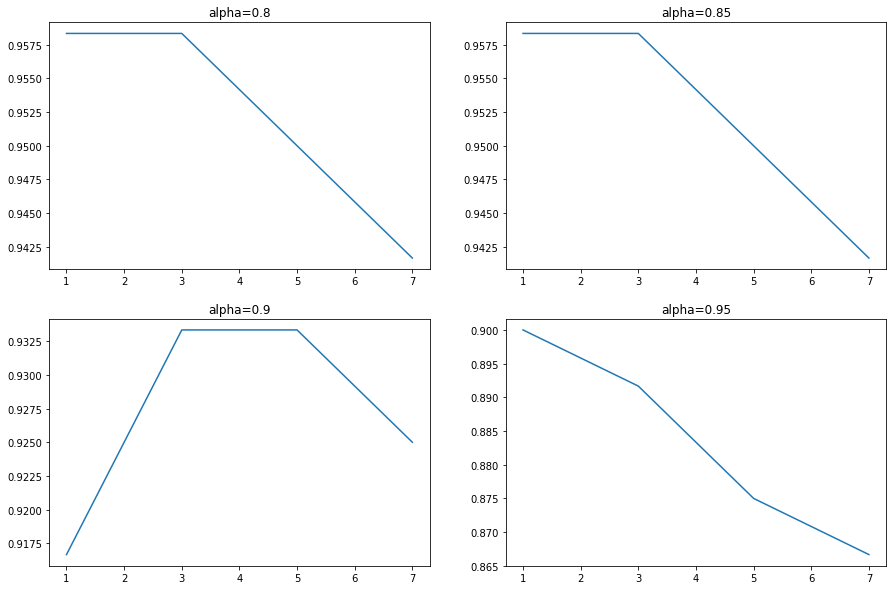

In [154]:
k=np.array([1,3,5,7])
figure, axis= plt.subplots(2,2, figsize=(15,10))
axis[0, 0].plot(k, accuracies[0:4])
axis[0, 0].set_title("alpha=0.8")

axis[0, 1].plot(k, accuracies[4:8])
axis[0, 1].set_title("alpha=0.85")

axis[1, 0].plot(k, accuracies[8:12])
axis[1, 0].set_title("alpha=0.9")

axis[1, 1].plot(k, accuracies[12:16])
axis[1, 1].set_title("alpha=0.95")

plt.show()

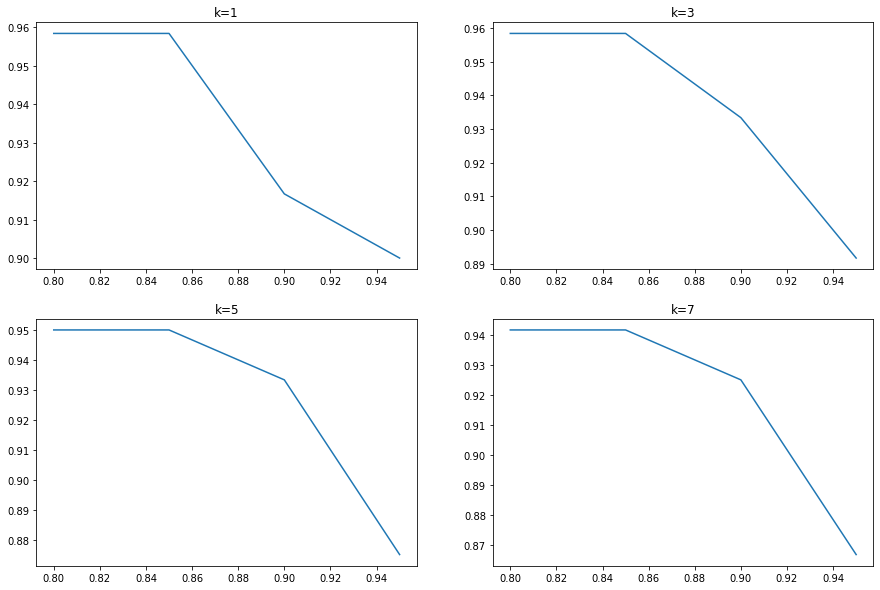

In [155]:
figure, axis= plt.subplots(2,2, figsize=(15,10))
axis[0, 0].plot(alpha, accuracies[0:16:4])
axis[0, 0].set_title("k=1")

axis[0, 1].plot(alpha, accuracies[1:16:4])
axis[0, 1].set_title("k=3")

axis[1, 0].plot(alpha, accuracies[2:16:4])
axis[1, 0].set_title("k=5")

axis[1, 1].plot(alpha, accuracies[3:16:4])
axis[1, 1].set_title("k=7")

plt.show()

Compare LDA results for different K

In [156]:
LDAaccuracies = np.array([])
kArray=np.array([])
for k in range(1, 8, 2):
    LDAaccuracies =  np.append(LDAaccuracies, knn(projectedTrain.T, projectedTest.T, trainLabel, testLabel,k ))
    kArray= np.append(kArray, k)

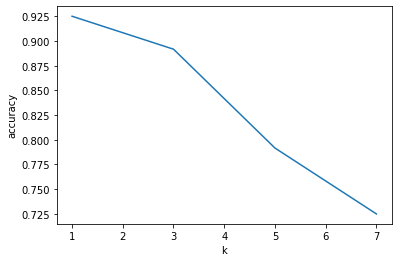

In [157]:
plt.plot(kArray, LDAaccuracies)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()